In [33]:
import os
import fnmatch
from copy import copy
import itertools
from datetime import datetime
from pathlib import Path
from collections import namedtuple

import geowombat as gw
# from tsplanet import download_data

import geopandas as gpd
import numpy as np
import numba as nb
from skimage.exposure import rescale_intensity
import cv2
import sklearn_crfsuite
from affine import Affine
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## Functions

In [3]:
# str_to_int_dict = dict(n=0, a=1, g=1, t=1, u=1, b=1, w=2, c=3, s=4, h=5)
# str_to_int_dict = dict(n=0, a=1, g=2, t=3, u=4, b=5, w=6, c=7, s=8, h=9)

str_to_int_dict = dict(n=0, l=1, u=2, w=3, c=4, s=5, h=6)

int_to_str_dict = dict()

for k, v in str_to_int_dict.items():

    # Change clear land values to 'l'
#     if v == 1:
#         int_to_str_dict[v] = 'l'
#     else:
    int_to_str_dict[v] = k

In [4]:
str_to_int_dict

{'n': 0, 'l': 1, 'u': 2, 'w': 3, 'c': 4, 's': 5, 'h': 6}

In [5]:
def str_to_int(row):
    str_values = row['class'].split(',')
    return ','.join([str(str_to_int_dict[sv]) for sv in str_values])

In [14]:
def label_decoder(label):
    return int_to_str_dict[label]


def get_sample_xy(sample):
    
    """
    Converts a DataFrame sample to a CRF feature
    """
    
    date_diff = sample.date2.to_pydatetime().toordinal() - sample.date1.to_pydatetime().toordinal()
    b_diff = int(sample.swir2) - int(sample.swir2_1)
    
    slab = band_names + ['date-diff', 'b-b']
    
    sfea = sample[band_names].values
    sfea = np.array(sfea.tolist() + [date_diff, b_diff], dtype='float64')

    return dict(zip(slab, sfea)), label_decoder(int(sample.poly))


def get_array_xy(sample):
    return dict(zip(band_names, sample))

    
def samples_to_features(dfs):
    
    """
    sample = [[{t1}, {t2}, ..., {tn}], ..., [...]]
    """
    
    return [list(zip(*df.apply(get_sample_xy, axis=1))) for df in dfs]


@nb.jit
def sample_to_dict(array_sample):

    slab = band_names + ['date-diff', 'b-b']
    
    # The last array is the date ordinal
    #sfea = np.array(array_sample.tolist() + [array_sample[-2] - array_sample[0]], dtype='float64')    
    sfea = np.float64(array_sample)
    
    return dict(zip(slab, sfea))    


@nb.jit
def array_to_dict(*args):
    
    """
    Converts array sample to a CRF features
    """
    
    return [sample_to_dict(sample) for sample in args]

In [63]:
def setup_names(grid, filenames):
    
    rpath_dict = {'t55jel': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't56jkt': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't55kcu': '/scratch/rsc8/hardtkel/rapidfires/LW/{}'.format(grid)}    
    
    NameInfo = namedtuple('NameInfo', 'rasters vector, time_names')
    
    vector_dir = Path('/scratch/rsc4/graesser/temp/s2/training')
    
    image_dir = Path(rpath_dict[grid])
    
    filename_dict = dict()
    for fn in filenames:
        filename_dict[fn.split('_')[2]] = fn

    sorted_names = list(zip(*sorted(filename_dict.items())))
    
    filenames = list(sorted_names[1])
    
    time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]
    
    rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
    vector = vector_dir.joinpath('{}.shp'.format(grid)).as_posix()
    
    return NameInfo(rasters=rasters, vector=vector, time_names=time_names)

## Extract samples from training AOIs

In [15]:
X = list()
y = list()

In [25]:
grid = 't56jkt'
# grid = 't55jel'
# grid = 't55kcu'

fnames_dict = {'t55jel': ['cemsre_t55jel_20171207_abbm5.img',
                          'cemsre_t55jel_20171227_abbm5.img',
                          'cemsre_t55jel_20180116_abbm5.img',
                          'cemsre_t55jel_20180317_abbm5.img',
                          'cemsre_t55jel_20180327_abbm5.img',
                          'cemsre_t55jel_20180406_abbm5.img',
                          'cemsre_t55jel_20180416_abbm5.img',
                          'cemsre_t55jel_20180426_abbm5.img',
                          'cemsre_t55jel_20180526_abbm5.img',
                          'cemsre_t55jel_20180605_abbm5.img',
                          'cemsre_t55jel_20180615_abbm5.img',
                          'cemsre_t55jel_20180715_abbm5.img',
                          'cemsre_t55jel_20180804_abbm5.img'],
              't56jkt': ['cemsre_t56jkt_20180423_abbm6.img',
                         'cemsre_t56jkt_20180513_abbm6.img',
                         'cemsre_t56jkt_20180523_abbm6.img',
                         'cemsre_t56jkt_20180602_abbm6.img'],
              't55kcu': ['cemsre_t55kcu_20171210_abbm5.img',
                         'cemsre_t55kcu_20171220_abbm5.img',
                         'cemsre_t55kcu_20171230_abbm5.img',
                         'cemsre_t55kcu_20180109_abbm5.img',
                         'cemsre_t55kcu_20180129_abbm5.img']}

rpath_dict = {'t55jel': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
              't56jkt': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
              't55kcu': '/scratch/rsc8/hardtkel/rapidfires/LW/{}'.format(grid)}

filenames = fnames_dict[grid]

band_names = ['nir1', 'nir2', 'nir3', 'rededge', 'swir1', 'swir2']
label_name = 'poly'

In [26]:
vector_dir = Path('/scratch/rsc4/graesser/temp/s2/training')
image_dir = Path(rpath_dict[grid])

filename_dict = dict()
for fn in filenames:
    filename_dict[fn.split('_')[2]] = fn
    
sorted_names = list(zip(*sorted(filename_dict.items())))

filenames = list(sorted_names[1])

time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]

rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
vector = vector_dir.joinpath('{}.shp'.format(grid)).as_posix()

In [27]:
df = gpd.read_file(vector)

df['class_len'] = df['class'].str.len()
df['int_class'] = df.apply(str_to_int, axis=1)
out = df['int_class'].str.split(',', expand=True)

df_list = list()

for s in range(0, out.shape[1]):
    df_ = df.copy()
    df_['id'] = out.iloc[:, s]
    df_list.append(df_)

print('Extracting samples ...')    
    
# Extract samples    
dfs = list()

with gw.config.update(sensor='s220'):

    with gw.open(rasters, time_names=time_names, chunks=512) as ds:    
       
        for ti, time in enumerate(ds.time.values):

            dss = ds.sel(time=time)
            
            dfe = dss.gw.extract(df_list[ti])
            
            if ti == 0:
                
                dfe['date1'] = time
                dfe['date2'] = time
                dfe['swir2_1'] = dfe.swir2
                
            else:
                
                dfe['date1'] = ds.time.values[ti-1]
                dfe['date2'] = time
                dfe['swir2_1'] = dfs[-1].swir2
            
            dfs.append(dfe)    
            
print('Converting samples to features ...')            
            
# Convert samples to features            
results = samples_to_features(dfs)
Xt = np.array(list(zip(*results))[0]).T.tolist()
yt = np.array(list(zip(*results))[1]).T.tolist()            

print('Finished')

Extracting samples ...


100%|██████████| 4/4 [00:00<00:00, 182.23it/s]


Converting samples to features ...
Finished


In [28]:
X += Xt
y += yt

### Fit the CRF model

In [112]:
# Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
model = sklearn_crfsuite.CRF(algorithm='lbfgs', 
                             c1=0.001,
                             c2=0.001,
                             max_iterations=10000,
                             num_memories=10,
                             epsilon=0.0001,
                             delta=0.0001,
                             period=10,
                             linesearch='StrongBacktracking',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
                             max_linesearch=20,
                             all_possible_states=True,
                             all_possible_transitions=True,
                             verbose=False)

In [113]:
# params_space = {'c1': [0.1, 0.01],
#                 'c2': [0.1, 0.01],
#                 'epsilon': [0.1, 0.01],
#                 'delta': [0.1, 0.01]}

# # use the same metric for evaluation
# f1_scorer = make_scorer(metrics.flat_f1_score,
#                         average='weighted', 
#                         labels=y)

# # search
# rs = RandomizedSearchCV(model, 
#                         params_space,
#                         cv=2,
#                         verbose=2,
#                         n_jobs=16,
#                         n_iter=20,
#                         scoring=f1_scorer)

# rs.fit(X, y)

In [114]:
# print('best params:', rs.best_params_)
# print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [115]:
model.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    averaging=None, c=None, c1=0.001, c2=0.001, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=0.0001, epsilon=0.0001,
    error_sensitive=None, gamma=None, keep_tempfiles=None,
    linesearch='StrongBacktracking', max_iterations=10000, max_linesearch=20,
    min_freq=None, model_filename=None, num_memories=10, pa_type=None,
    period=10, trainer_cls=None, variance=None, verbose=False)

### Open the data to predict on 

In [64]:
image_info = setup_names('t55kcu', fnames_dict['t55kcu'])

In [65]:
with gw.config.update(sensor='s2l7'):
    
    with gw.open(image_info.rasters, 
                 time_names=image_info.time_names, 
                 chunks=512) as ds:
        
        dss = gw.subset(ds, left=348713.414, top=7820035.516, rows=512+256, cols=512+256)
        
        test = dss.astype('float64').data.compute()

In [66]:
test.shape

(5, 6, 768, 768)

In [67]:
ntime, nbands, nrows, ncols = test.shape

### Add date ordinals

In [70]:
stacked_arrays = list()

for di in range(0, len(image_info.time_names)):
    
    ordinal_array = np.zeros((nrows, ncols), dtype='uint64')
    b_diff_array = np.zeros((nrows, ncols), dtype='uint64')
    
    if di > 0:
        
        date_diff = image_info.time_names[di].toordinal() - image_info.time_names[di-1].toordinal()

        #date_diff = dfs[di].iloc[0].date2.to_pydatetime().toordinal() - dfs[di-1].iloc[0].date1.to_pydatetime().toordinal()
        ordinal_array = ordinal_array + date_diff
        
        b_diff_array = test[di][-1] - test[di-1][-1]
    
    stacked_arrays.append(np.concatenate((test[di], 
                                          ordinal_array[np.newaxis, :, :],
                                          b_diff_array[np.newaxis, :, :])))
    
stacked_arrays = np.array(stacked_arrays)    

In [71]:
stacked_arrays.shape

(5, 8, 768, 768)

In [72]:
ntime, nbands, nrows, ncols = stacked_arrays.shape

### Convert the array to CRF-compatible features

In [73]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in stacked_arrays]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

### Predict on all time steps

In [116]:
pred = model.predict_marginals(features)

In [117]:
def pred_to_labels(model_pred):
    
    # samples x time x n classes
    return np.array([[[ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] for p in model_pred], dtype='float64')

In [118]:
# samples x time x n classes
# pred = np.array([[[ps['n'], ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] 
#                  for p in model.predict_marginals(features)], dtype='float64')

In [119]:
pred = pred_to_labels(pred)

In [120]:
pred.shape

(589824, 5, 5)

In [121]:
pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [122]:
pred.shape

(5, 5, 768, 768)

## Plot probabilities

<IPython.core.display.Javascript object>


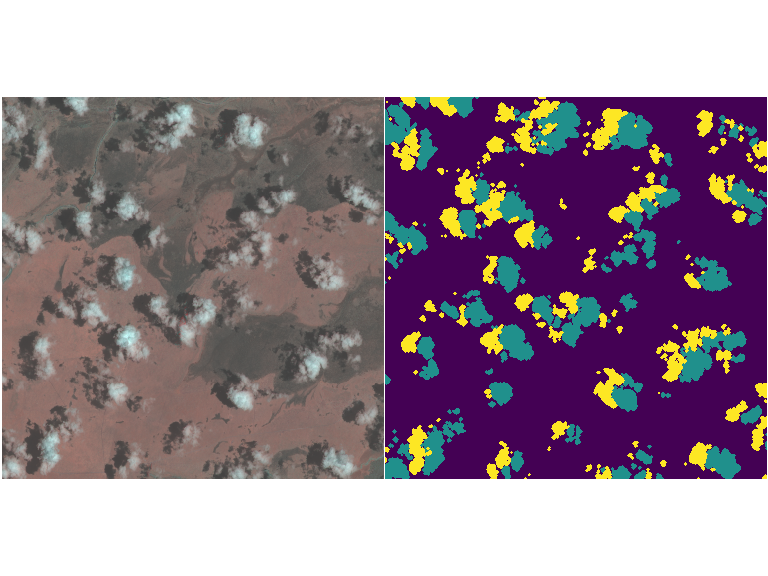

In [136]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=120)

# pr_max = pred[: 2, :, :].max(axis=0)
idx = 3

#proba = pred[idx, 2:, :, :].max(axis=0) #- pred[:idx-1, 2, :, :].cumsum(axis=0)[-1, :, :]
pred_int = pred[idx, :, :, :].argmax(axis=0)
pred_int = np.uint8(np.where(pred_int == 2, 1, np.where(pred_int == 3, 2, 0)))
pred_int = cv2.dilate(pred_int, np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype='uint8'), iterations=3)

ip = test[idx, 2:5, :, :]
ip = rescale_intensity(ip, 
                       in_range=(ip.min(), ip.max()), 
                       out_range=(np.nanpercentile(ip, 10), 
                                  np.nanpercentile(ip, 95)))
ip = np.flip(ip, axis=0)
ip = np.ascontiguousarray(ip.transpose(1, 2, 0))
ip /= ip.max()

ax1.imshow(ip)
#ax1.imshow(ip, vmin=np.nanpercentile(ip, 5), vmax=np.nanpercentile(ip, 95), cmap='viridis')

#ax2.imshow(proba, vmin=np.nanpercentile(proba, 5), vmax=np.nanpercentile(proba, 95), cmap='magma')
ax2.imshow(pred_int, vmin=0, vmax=2)

ax1.axis('off')
ax2.axis('off')

plt.tight_layout(pad=0.1)

plt.show()

In [ ]:
pred.shape

In [ ]:
fig, axes = plt.subplots(pred.shape[0], 2, dpi=400, figsize=(2, 12))

bidx = 0 # band index
cidx = 2 # class index

for pi in range(0, pred.shape[0]):

    ip = test[pi, bidx, :, :]
    #ip[ip == 0] = np.nan
    
#     pr = pred[pi, cidx, :, :]
#     pr = (pr_max - pr) / (pr_max + pr)
#     pr = (pr + pr_max) / 2.0
    
    pred_int = pred[pi, :, :, :].argmax(axis=0)
    pred_int = np.where(pred_int == 2, 1, np.where(pred_int == 3, 2, 0))
    
    axes[pi][0].imshow(ip, vmin=np.nanpercentile(ip, 5), vmax=np.nanpercentile(ip, 95), cmap='viridis')
    #axes[pi][1].imshow(pr, vmin=np.nanpercentile(pr, 5), vmax=np.nanpercentile(pr, 95), cmap='bone')
    axes[pi][1].imshow(pred_int, vmin=0, vmax=2)
    
    axes[pi][0].axis('off')
    axes[pi][1].axis('off')

plt.show()